## NEON data

Next: check other networks shown in http://nationalsoilmoisture.com/

### This notebook requires that SMCalVal_NEON_setup has been run successfully

### This notebook performs the following:
- Loads previously generated siteList.json file
- Extracts NISAR retrieval dates and values from each track
- Extracts in situ data values for each NISAR date
- Populates csv file for each track/frame, including NISAR values at the pixel and 5 station values on the relevant dates.

### Notes


### Cite provisional data as:
NEON (National Ecological Observatory Network). Soil water content and water salinity (DP1.00094.001), provisional data. Dataset accessed from https://data.neonscience.org/data-products/DP1.00094.001 on Month, Day, Year. Data archived at [your DOI].

### Cite Released data as:
NEON (National Ecological Observatory Network). Soil water content and water salinity (DP1.00094.001), RELEASE-2024. https://doi.org/10.48443/a8vy-y813. Dataset accessed from https://data.neonscience.org/data-products/DP1.00094.001/RELEASE-2024 on Month, Day, Year.

In [1]:
import os
import glob
from pathlib import Path
import requests
import json
from osgeo import gdal,osr,ogr
import datetime
import pandas as pd
import geopandas as gpd
import shapely
import numpy as np
import h5py
import csv
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.dates import DateFormatter
import matplotlib.path as mpltPath
import re
from utilsCalVal import EASEconvert
import setParams as p
import wget

In [2]:
neonPath      = '/scratch/rlohman/SMCalVal/NEON/'
neonFile      = neonPath+'siteList.json'

if not(os.path.isfile(neonFile)):
    print('Need to run SMCalVal_NEON_setup to generate track/frame/site file')

startDate     = datetime.datetime(2021,4,1)
endDate       = datetime.datetime(2024,4+1,1)+datetime.timedelta(microseconds=-1)

In [3]:
with open(neonFile) as f:
    sites = json.load(f)

In [4]:
print(sites[0])

{'siteCode': 'ABBY', 'lat': 45.762439, 'lon': -122.330317, 'EASEGridRowIndex': 10319, 'EASEGridColIndex': 27796, 'lulc': 1, 'dem': 2.2055230140686035, 'crop': 255, 'web': 'https://www.neonscience.org/field-sites/abby', 'tracks': [34, 71, 172, 106, 34], 'frames': [24, 65, 65, 25, 25], 'HVpos': ['001.502', '002.502', '003.502', '004.502', '005.502'], 'depths': [-0.16, -0.16, -0.16, -0.17, -0.16], 'framecount': 5}


In [5]:
SERVER      = 'http://data.neonscience.org/api/v0/'
productCode = 'DP1.00094.001'
url         = SERVER+'products/'+productCode

#Request the url and convert to json
site_json   = requests.get(url).json()

For testing only - come up with list of dates from SAR acquisitions.  Here use Walnut Gulch, A

In [26]:
def getSMRetAtPt(ezr,ezc,track,frame,directory):
    mods=('DSG','PMI','TSR')
    R4dir = '/home/jovyan/WalnutGulchA/Path62Frame620BeamFP66/R4/'
    outFiles     = np.array(glob.glob(R4dir+('[0-9]'*8)+'.h5'))
    
    # #find index of begin/end of dates, assume format same for all
    tmp          = re.search(r'2[0-9]{7}',outFiles[0])
    inds         = tmp.span()
    dates        = np.array([datetime.datetime.strptime(x[inds[0]:inds[1]],'%Y%m%d') for x in outFiles])
    sort_index   = np.argsort(dates)
    gcovs        = outFiles[sort_index]
    dates        = dates[sort_index]
   
    dataset='/science/LSAR/identification/zeroDopplerStartTime'

    for dateindex in range(len(dates)):
        fo=h5py.File(gcovs[dateindex],'r')
        if dataset in fo:
            tmp      = fo[dataset][()]
            dates[dateindex] = datetime.datetime.strptime(tmp.decode('utf-8'),'%Y-%m-%dT%H:%M:%S')
    
    datestr = np.array([x.strftime('%Y-%m-%dT%H:%M:%S') for x in dates])
    
    #for NISAR, all grids should be same.
    eci = fo['/science/LSAR/SME2/grids/EASEGridColumnIndex'][()]
    eri = fo['/science/LSAR/SME2/grids/EASEGridRowIndex'][()]
    fo.close()
    
    idx = np.array([np.linalg.norm(x) for x in eci-ezc]).argmin()
    idy = np.array([np.linalg.norm(x) for x in eri-ezr]).argmin()
    print(idx,idy)
    idx=150
    idy=150
    retr= np.zeros([len(dates),len(mods)])*np.nan
    rete= np.zeros([len(dates),len(mods)])*np.nan
    retf= np.zeros([len(dates),len(mods)])*np.nan
    for dateindex in range(len(dates)):
        fo=h5py.File(gcovs[dateindex],'r')

        for modindex in range(len(mods)):
            dataset='/science/LSAR/SME2/grids/algorithmCandidates/'+mods[modindex]+'/soilMoisture'
            if dataset in fo:
                retr[dateindex,modindex] =fo[dataset][idy,idx]
            dataset='/science/LSAR/SME2/grids/algorithmCandidates/'+mods[modindex]+'/soilMoistureUncertainty'
            if dataset in fo:
                rete[dateindex,modindex] =fo[dataset][idy,idx]
            dataset='/science/LSAR/SME2/grids/algorithmCandidates/'+mods[modindex]+'/retrievalQualityFlag'
            if dataset in fo:
                retf[dateindex,modindex] =fo[dataset][idy,idx]
        fo=None

    outfile=directory+'/T'+str(track)+'F'+str(frame)+'X'+str(idx)+'Y'+str(idy)+'.csv'


    #do this in pandas, don't write yet.
    with open(outfile, 'w', newline='') as csvfile:
        fieldnames = ['Date','DSGsm','DSGunc','DSGflag']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for dateindex in range(len(dates)):
            writer.writerow({'Date':datestr[dateindex],'DSGsm':retr[dateindex,0],'DSGunc':rete[dateindex,0],'DSGflag':retf[dateindex,0]})
    return df

In [27]:
### start by getting dates for each frame
for site in sites:
    ezr    = site['EASEGridRowIndex']
    ezc    = site['EASEGridColIndex']
    if site['siteCode'] in ['SRER']: #near Walnut Gulch
        for i in range(site['framecount']):
            t      = site['tracks'][i]
            f      = site['frames'][i]
            df[i] = getSMRetAtPt(ezr,ezc,t,f,neonPath+site['siteCode']+'/')
            #pull list of dates, assoc with "i" (frameid) and append to old lists
        #sort dates, "i"s
        date0=min(date)
        dateN=max(date)
        #iterate through months
        allmonths = [2021-01:2024-07 or something like that]
        for month in allmonths:
        #identify dates in that month
            filename = ''
            tmpdata = pd.read_csv(u2)
            ts = np.array([datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%SZ') for x in tmpdata['startDateTime']])
            for i in range(site['framecount']):
                for date in dates: #get list of dates from df
                    print(dates[i])
                    rowid        = np.argmin(np.abs(ts-dates[i]))
                    insituDat[i] = tmpdata['VSWCMean'][rowid]
                    insituQ[i]   = tmpdata['VSWCFinalQF'][rowid]



0 24
0 24
0 24
0 24


In [ ]:
'https://storage.googleapis.com/neon-publication/NEON.DOM.SITE.DP1.00094.001/SRER/20210401T000000--20210501T000000/basic/NEON.D14.SRER.DP1.00094.001.002.507.030.SWS_30_minute.2021-04.basic.20221210T222308Z.csv'

In [7]:
# insituDat = np.zeros([len(dates),1])
# insituQ   = np.zeros([len(dates),1])

# #change this to do it only once, not 5x!!!
# for site in sites:
#     if site['siteCode'] in ['SRER']: #near Walnut Gulch
#         print(site['HVpos'])
#         siteID   = [i for i,x in enumerate([sub['siteCode'] in [site['siteCode']] for sub in site_json['data']['siteCodes'] ] ) if x][0]
#         st       = site_json['data']['siteCodes'][siteID] 
#         months   = np.array([datetime.datetime.strptime(x, '%Y-%m') for x in st['availableMonths']]) #convert from YYYY-MM to datetime
#         urls     = np.array(st['availableDataUrls'])
#         urls     = urls[months>=startDate]
#         for u in urls:
#             s2=requests.get(u).json()
#             for file in s2['data']['files']:
#                 u2 = file['url']
#                 if 'basic' in u2 and site['HVpos']+'.030' in u2 and 'variables' not in u2:
#                     tmpdata = pd.read_csv(u2)
#                     ts = np.array([datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%SZ') for x in tmpdata['startDateTime']])
#                     for i in range(len(dates)):
#                         if fileDates[i] in u:
#                             print(dates[i])
#                             rowid        = np.argmin(np.abs(ts-dates[i]))
#                             insituDat[i] = tmpdata['VSWCMean'][rowid]
#                             insituQ[i]   = tmpdata['VSWCFinalQF'][rowid]
   


['001.502', '002.502', '003.502', '004.502', '005.502']


TypeError: can only concatenate list (not "str") to list

In [11]:
print(s2['data']['files'])

[{'name': 'NEON.D14.SRER.DP1.00094.001.004.506.001.SWS_1_minute.2021-04.basic.20221210T222308Z.csv', 'size': 6089906, 'md5': '15c5948bab23754c3c78dd8ccd44e8f3', 'crc32': None, 'crc32c': None, 'url': 'https://storage.googleapis.com/neon-publication/NEON.DOM.SITE.DP1.00094.001/SRER/20210401T000000--20210501T000000/basic/NEON.D14.SRER.DP1.00094.001.004.506.001.SWS_1_minute.2021-04.basic.20221210T222308Z.csv'}, {'name': 'NEON.D14.SRER.DP1.00094.001.002.507.030.SWS_30_minute.2021-04.basic.20221210T222308Z.csv', 'size': 209825, 'md5': 'd35778791bf91f7448c87438f836f4b2', 'crc32': None, 'crc32c': None, 'url': 'https://storage.googleapis.com/neon-publication/NEON.DOM.SITE.DP1.00094.001/SRER/20210401T000000--20210501T000000/basic/NEON.D14.SRER.DP1.00094.001.002.507.030.SWS_30_minute.2021-04.basic.20221210T222308Z.csv'}, {'name': 'NEON.D14.SRER.DP1.00094.001.001.507.001.SWS_1_minute.2021-04.basic.20221210T222308Z.csv', 'size': 5436774, 'md5': '2ffe5af1890a57d9814449dc2695e2de', 'crc32': None, 'cr

In [70]:
months   = np.array([datetime.datetime.strptime(x, '%Y-%m') for x in st['availableMonths']]) #convert from YYYY-MM to datetime
urls     = np.array(st['availableDataUrls'])
urls     = urls[months>=startDate]
print(urls)

['https://data.neonscience.org/api/v0/data/DP1.00094.001/SRER/2021-04'
 'https://data.neonscience.org/api/v0/data/DP1.00094.001/SRER/2021-05'
 'https://data.neonscience.org/api/v0/data/DP1.00094.001/SRER/2021-06'
 'https://data.neonscience.org/api/v0/data/DP1.00094.001/SRER/2021-07'
 'https://data.neonscience.org/api/v0/data/DP1.00094.001/SRER/2021-08'
 'https://data.neonscience.org/api/v0/data/DP1.00094.001/SRER/2021-09'
 'https://data.neonscience.org/api/v0/data/DP1.00094.001/SRER/2021-10'
 'https://data.neonscience.org/api/v0/data/DP1.00094.001/SRER/2021-11'
 'https://data.neonscience.org/api/v0/data/DP1.00094.001/SRER/2021-12'
 'https://data.neonscience.org/api/v0/data/DP1.00094.001/SRER/2022-01'
 'https://data.neonscience.org/api/v0/data/DP1.00094.001/SRER/2022-02'
 'https://data.neonscience.org/api/v0/data/DP1.00094.001/SRER/2022-03'
 'https://data.neonscience.org/api/v0/data/DP1.00094.001/SRER/2022-04'
 'https://data.neonscience.org/api/v0/data/DP1.00094.001/SRER/2022-05'
 'http

{'siteCode': 'SRER', 'lat': 31.91068, 'lon': -110.83549, 'EASEGridRowIndex': 17214, 'EASEGridColIndex': 33337, 'lulc': 2, 'dem': 0.13640232384204865, 'crop': 255, 'web': 'https://www.neonscience.org/field-sites/srer', 'tracks': [77, 128, 149, 77], 'frames': [17, 72, 18, 18], 'HVpos': '002.502', 'depths': -0.162, 'framecount': 4}
45 46


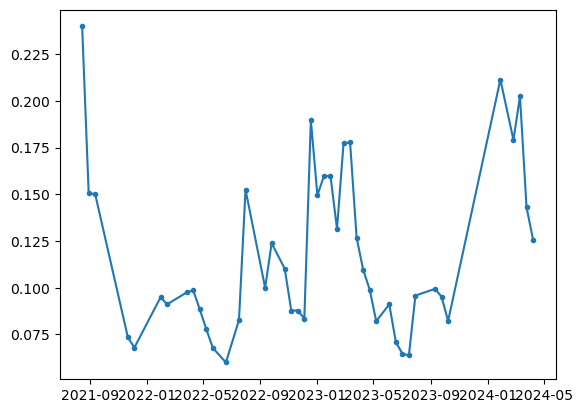

In [61]:
print(site)
print(i,len(dates))
plt.plot(dates,insituDat,'.-')

In [49]:
ts=np.array([datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%SZ') for x in a['startDateTime']])

In [53]:
print(a)

              startDateTime           endDateTime  VSWCMean  VSWCMinimum   
0      2024-04-01T00:00:00Z  2024-04-01T00:01:00Z       NaN          NaN  \
1      2024-04-01T00:01:00Z  2024-04-01T00:02:00Z       NaN          NaN   
2      2024-04-01T00:02:00Z  2024-04-01T00:03:00Z       NaN          NaN   
3      2024-04-01T00:03:00Z  2024-04-01T00:04:00Z       NaN          NaN   
4      2024-04-01T00:04:00Z  2024-04-01T00:05:00Z       NaN          NaN   
...                     ...                   ...       ...          ...   
43195  2024-04-30T23:55:00Z  2024-04-30T23:56:00Z       NaN          NaN   
43196  2024-04-30T23:56:00Z  2024-04-30T23:57:00Z       NaN          NaN   
43197  2024-04-30T23:57:00Z  2024-04-30T23:58:00Z       NaN          NaN   
43198  2024-04-30T23:58:00Z  2024-04-30T23:59:00Z       NaN          NaN   
43199  2024-04-30T23:59:00Z  2024-05-01T00:00:00Z       NaN          NaN   

       VSWCMaximum  VSWCVariance  VSWCNumPts  VSWCExpUncert  VSWCStdErMean   
0        

In [51]:
print(dates[i])
print(ts[9078])

2024-04-07 07:18:16
2024-04-07 07:18:00


In [54]:
print(a.columns)

Index(['startDateTime', 'endDateTime', 'VSWCMean', 'VSWCMinimum',
       'VSWCMaximum', 'VSWCVariance', 'VSWCNumPts', 'VSWCExpUncert',
       'VSWCStdErMean', 'VSWCRangeFailQM', 'VSWCRangePassQM', 'VSWCRangeNAQM',
       'VSWCPersistenceFailQM', 'VSWCPersistencePassQM', 'VSWCPersistenceNAQM',
       'VSWCStepFailQM', 'VSWCStepPassQM', 'VSWCStepNAQM', 'VSWCNullFailQM',
       'VSWCNullPassQM', 'VSWCNullNAQM', 'VSWCGapFailQM', 'VSWCGapPassQM',
       'VSWCGapNAQM', 'VSWCSpikeFailQM', 'VSWCSpikePassQM', 'VSWCSpikeNAQM',
       'VSWCValidCalFailQM', 'VSWCValidCalPassQM', 'VSWCValidCalNAQM',
       'VSWCAlphaQM', 'VSWCBetaQM', 'VSWCFinalQF', 'VSWCFinalQFSciRvw',
       'VSICMean', 'VSICMinimum', 'VSICMaximum', 'VSICVariance', 'VSICNumPts',
       'VSICExpUncert', 'VSICStdErMean', 'VSICRangeFailQM', 'VSICRangePassQM',
       'VSICRangeNAQM', 'VSICPersistenceFailQM', 'VSICPersistencePassQM',
       'VSICPersistenceNAQM', 'VSICStepFailQM', 'VSICStepPassQM',
       'VSICStepNAQM', 'VSICNullFail